In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from jcopml.plot import plot_missing_value

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-price-classification/train.csv
/kaggle/input/mobile-price-classification/test.csv


# Import Datasets

In [25]:
pd.set_option('display.max_columns', 500)
df = pd.read_csv('/kaggle/input/mobile-price-classification/train.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


## Number of columns and rows

In [26]:
df.shape

(2000, 21)

## Correlation Matrix

In [27]:
from jcopml.plot import plot_correlation_matrix
plot_correlation_matrix(df, 'price_range', numeric_col=["battery_power", "clock_speed", "fc", 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time'])

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…

Based on the correlation matrix results, we will only use four columns

In [28]:
kolom_yg_dipakai = ["battery_power", "ram", "px_height", "px_width", "price_range"]
df_new = df[kolom_yg_dipakai]

In [29]:
print(df_new.shape)
df_new.head()

(2000, 5)


,battery_power,ram,px_height,px_width,price_range
0,842,2549,20,756,1
1,1021,2631,905,1988,2
2,563,2603,1263,1716,2
3,615,2769,1216,1786,2
4,1821,1411,1208,1212,1


## Check Missing Value
there is no missing value. Data ready for processing

,missing_value,%
battery_power,0,0.0
ram,0,0.0
px_height,0,0.0
px_width,0,0.0
price_range,0,0.0


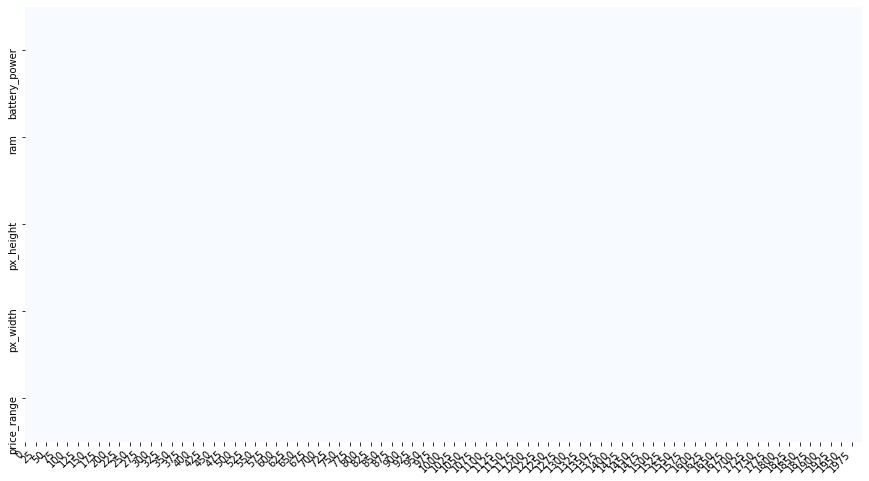

In [30]:
plot_missing_value(df_new, return_df=True)

# Histogram

count    2000.000000
mean     1238.518500
std       439.418206
min       501.000000
25%       851.750000
50%      1226.000000
75%      1615.250000
max      1998.000000
Name: battery_power, dtype: float64 

count    2000.000000
mean     2124.213000
std      1084.732044
min       256.000000
25%      1207.500000
50%      2146.500000
75%      3064.500000
max      3998.000000
Name: ram, dtype: float64 

count    2000.000000
mean      645.108000
std       443.780811
min         0.000000
25%       282.750000
50%       564.000000
75%       947.250000
max      1960.000000
Name: px_height, dtype: float64 

count    2000.000000
mean     1251.515500
std       432.199447
min       500.000000
25%       874.750000
50%      1247.000000
75%      1633.000000
max      1998.000000
Name: px_width, dtype: float64 



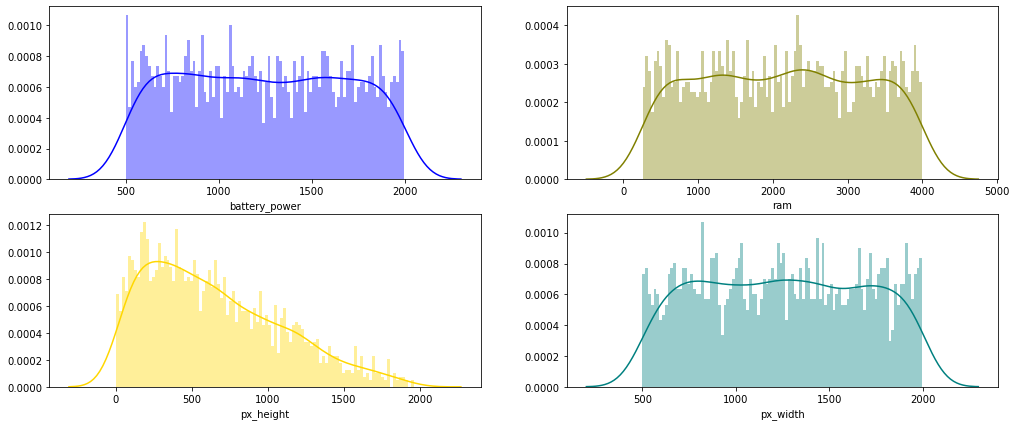

In [31]:
[print(df[x].describe(), "\n") for x in df_new.columns if x!='price_range']

f, axes = plt.subplots(2, 2, figsize=(17, 7), sharex=False)
sns.distplot( df["battery_power"], bins=100, color="blue", ax=axes[0, 0])
sns.distplot( df["ram"], bins=100, color="olive", ax=axes[0, 1])
sns.distplot( df["px_height"], bins=100, color="gold", ax=axes[1, 0])
sns.distplot( df["px_width"], bins=100, color="teal", ax=axes[1, 1])

# Scatter Plot

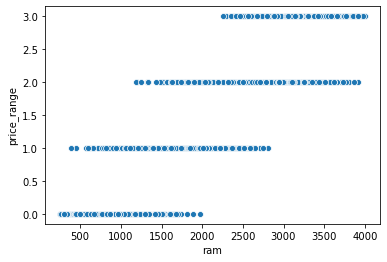

In [32]:
sns.scatterplot(x=df["ram"], y=df["price_range"])

## Check the relationship using Pairplot
it can be seen that the most affecting parameter is the RAM column

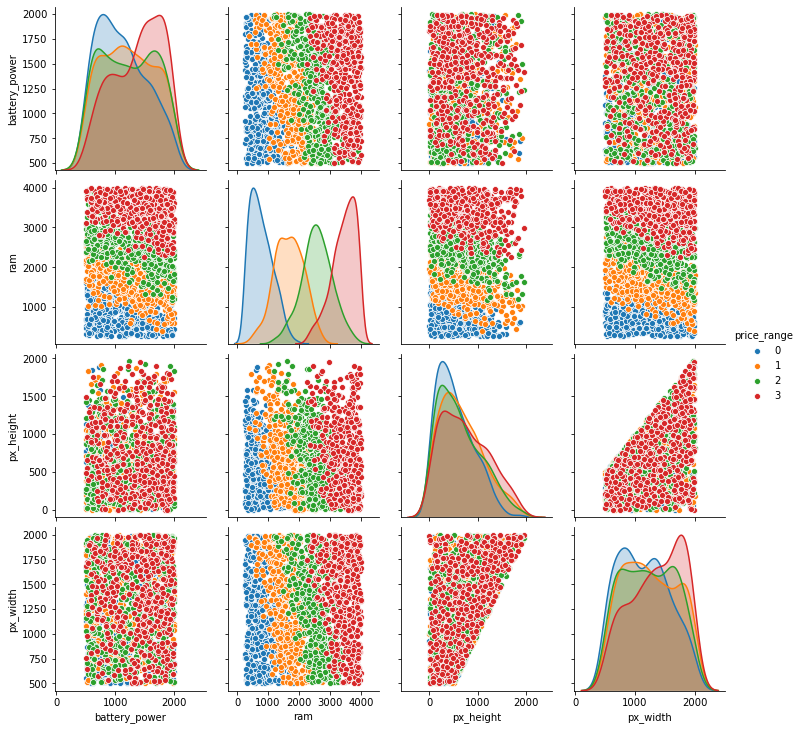

In [33]:
sns.pairplot(df_new,hue='price_range')

# Datasets Splitting

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [35]:
# Separate the features and target columns
X = df_new.drop(columns=["price_range"])
y = df_new["price_range"]

# Create data train and data test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 4), (400, 4), (1600,), (400,))

# Modeling - SVM Classifier

In [36]:
from sklearn.svm import SVC 
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import grid_search_params as gsp

In [37]:
parameter_tune = {'algo__gamma': [1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03],
'algo__C': [1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03],
'algo__max_iter' : [100, 200, 300, 400, 500, 600]}

preprocessing = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns),
])

pipeline = Pipeline([
    ('prep', preprocessing),
    ('algo', SVC())
])

model = RandomizedSearchCV(pipeline, parameter_tune,cv=3, n_jobs=-1, verbose=1, n_iter=150)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   13.9s


{'algo__max_iter': 200, 'algo__gamma': 0.001, 'algo__C': 1.0}
0.97 0.8974956257773469 0.91


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   16.5s finished
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


## Improve SVM Classifier with scalling, and transform

In [38]:
parameter_tune = {'algo__gamma': [1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03],
'algo__C': [1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03],
'algo__max_iter' : [100, 200, 300, 400, 500, 600]}

preprocessing = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform='yeo-johnson'), X_train.columns),
])

pipeline = Pipeline([
    ('prep', preprocessing),
    ('algo', SVC())
])

model = RandomizedSearchCV(pipeline, parameter_tune,cv=3, n_jobs=-1, verbose=1, n_iter=200)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

/opt/conda/lib/python3.7/site-packages/jcopml/pipeline/_pipeline.py:65: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   19.8s


{'algo__max_iter': 400, 'algo__gamma': 0.1, 'algo__C': 100.0}
0.96875 0.9506198864927283 0.965


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   26.6s finished
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [39]:
parameter_tune = {'algo__gamma': [1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03],
'algo__C': [1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03],
'algo__max_iter' : [100, 200, 300, 400, 500, 600]}

preprocessing = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), X_train.columns),
])

pipeline = Pipeline([
    ('prep', preprocessing),
    ('algo', SVC())
])

model = RandomizedSearchCV(pipeline, parameter_tune,cv=3, n_jobs=-1, verbose=1, n_iter=200)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   12.0s


{'algo__max_iter': 200, 'algo__gamma': 0.001, 'algo__C': 1000.0}
0.95125 0.956250746604268 0.9725


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   19.3s finished
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


## Improve SVM Classifier Poly

In [40]:
parameter_tune = {
'prep__numeric__poly__degree': [2, 3, 4],
 'prep__numeric__poly__interaction_only': [True, False],
'algo__gamma': [1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03],
'algo__C': [1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03],
'algo__max_iter' : [100, 200, 300, 400, 500, 600]}

preprocessing = ColumnTransformer([
    ('numeric', num_pipe(poly=2 ,scaling='robust'), X_train.columns),
])

pipeline = Pipeline([
    ('prep', preprocessing),
    ('algo', SVC())
])

model = RandomizedSearchCV(pipeline, parameter_tune,cv=3, n_jobs=-1, verbose=1, n_iter=200)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   24.8s


{'prep__numeric__poly__interaction_only': False, 'prep__numeric__poly__degree': 2, 'algo__max_iter': 300, 'algo__gamma': 0.01, 'algo__C': 100.0}
0.95875 0.9524995725324583 0.9725


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   34.1s finished
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


# Evaluation

In [41]:
from jcopml.plot import plot_classification_report, plot_confusion_matrix, plot_roc_curve, plot_pr_curve

Classification Report

In [42]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.95      0.96      0.96       400
           2       0.94      0.94      0.94       400
           3       0.96      0.96      0.96       400

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600


Test report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.98      0.97      0.97       100
           2       0.95      0.94      0.94       100
           3       0.96      0.98      0.97       100

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



Plot Confussion Matrix

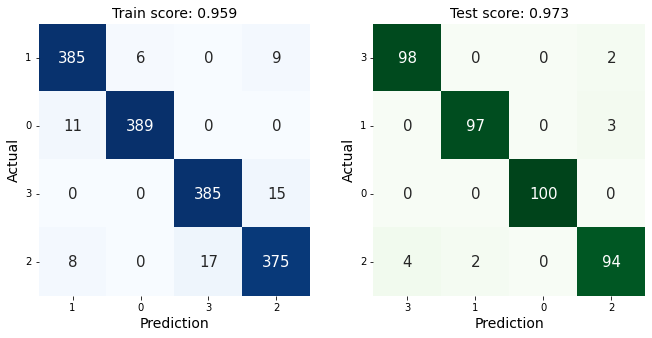

In [43]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)